## Задание

Построить график accuracy top 5 для различных моделей из Keras на примере датасета [imagenette](https://github.com/fastai/imagenette). 


In [ ]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from statistics import mean
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, efficientnet
from tensorflow.keras.applications import imagenet_utils

In [ ]:
# Набор вспомогательных методов

def get_model(model_name):
    if model_name == 'vgg16':
        model = vgg16.VGG16(weights='imagenet')
    elif model_name == 'inception_v3':
        model = inception_v3.InceptionV3(weights='imagenet')
    elif model_name == 'resnet50':
        model = resnet50.ResNet50(weights='imagenet')
    elif model_name == 'mobilenet':
        model = mobilenet.MobileNet(weights='imagenet')
    elif model_name == 'efficientnet':
        model = efficientnet.EfficientNetB6(weights='imagenet')
    return model

def get_helper_module(model_name):
    if model_name == 'vgg16':
        return vgg16
    elif model_name == 'inception_v3':
        return inception_v3
    elif model_name == 'resnet50':
        return resnet50
    elif model_name == 'mobilenet':
        return mobilenet
    elif model_name == 'efficientnet':
        return efficientnet

In [ ]:
dataset_path = "imagenette2"
if not os.path.exists(dataset_path):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar -xzf imagenette2.tgz

--2022-11-19 13:27:36--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.191.8, 52.216.170.61, 52.217.162.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.191.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  12.5MB/s    in 2m 3s   

2022-11-19 13:29:40 (12.1 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



Подгружаем датасет

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dir_path = Path('/content/imagenette2/val/')

Ф-ция top 5 accuracy:

In [ ]:
def top_k_accuracy(y_pred, y_true, k):
  true = 0
  for idx in range(len(y_true)):    
    if y_true[idx] in y_pred[idx][:k]:
      true += 1  
  return (true / len(y_true))

В цикле проходимся по всем моделям из списка и вычисляем top 5 accuracy

In [ ]:
MODELS_NAMES = ['inception_v3', 'resnet50', 'vgg16', 'mobilenet', 'efficientnet']
top_k_acc_model = []
model_params = []

for name in MODELS_NAMES:
  top_k_acc = []
  model = get_model(name)
  helper_module = get_helper_module(name)
  print(name + ':')

  valid_datagen = ImageDataGenerator(preprocessing_function=helper_module.preprocess_input)
  valid_gen = valid_datagen.flow_from_directory(
    dir_path,
    shuffle=True, seed=42, 
    target_size=model.input_shape[1:-1],
    batch_size=64
  )  
  
  count = 1
  for batch_x, batch_y in valid_gen:
    preds = model.predict(batch_x, steps=1, verbose=0)
    preds_decoded = helper_module.decode_predictions(preds, top=5)
    preds_decoded = np.array(preds_decoded)
    preds_decoded.shape

    y_true_indexs = np.where(batch_y == 1)[1]
    y_true_labels = []
    for idx in y_true_indexs:
      y_true_labels.append(list(valid_gen.class_indices.items())[idx][0])

    top_k_acc.append(top_k_accuracy(preds_decoded, y_true_labels, 5))

    count += 1
    if count > valid_gen.__len__():
      break
    
  model_params.append(model.count_params())
  top_k_acc_model.append(mean(top_k_acc))

m_idx = 0
for name in MODELS_NAMES:
  print('model: ' + name + ', top 5 accuracy: ' + str(top_k_acc_model[m_idx]))
  m_idx += 1 


inception_v3:
Found 3925 images belonging to 10 classes.
resnet50:
Found 3925 images belonging to 10 classes.
vgg16:
Found 3925 images belonging to 10 classes.
mobilenet:
Found 3925 images belonging to 10 classes.
efficientnet:
Found 3925 images belonging to 10 classes.
model: inception_v3, top 5 accuracy: 0.9879032258064516
model: resnet50, top 5 accuracy: 0.9601814516129032
model: vgg16, top 5 accuracy: 0.920098886328725
model: mobilenet, top 5 accuracy: 0.9810987903225806
model: efficientnet, top 5 accuracy: 0.9977318548387096


Строим график точности моделей от числа ее параметров

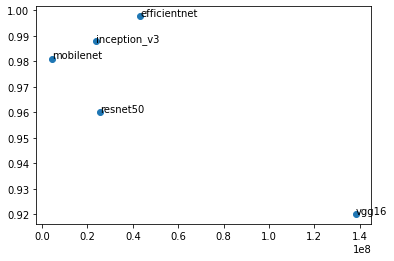

In [ ]:
fig = plt.figure()
plt.scatter(model_params, top_k_acc_model)
for i, txt in enumerate(MODELS_NAMES):
  plt.text(model_params[i], top_k_acc_model[i], txt)
plt.show()